Step-by-step EDA + modeling pipeline for the uploaded dataset.
Each block contains comments explaining its purpose and the Python techniques used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import math

In [2]:
# Optional: helper to display DataFrames in the notebook UI (if available)
try:
    from caas_jupyter_tools import display_dataframe_to_user
    can_display = True
except Exception:
    # If not available, we'll fallback to printing tables
    can_display = False

In [10]:
# ---------- 1. Load the data ----------
file_path = 'Desktop/PGDM_BDA_L_8_DataSet.csv'   # update path if needed
df = pd.read_csv(file_path)                        # <-- correct function for CSV

In [11]:
# Show basic info (shape & head)
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

Dataset shape: (50000, 7)

First 5 rows:


,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [12]:
# ---------- 2. Standardize column names & quick cleanup ----------
# Make column names python-friendly: lowercase, strip, replace spaces with underscores
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Rename long column names if necessary
# For example 'year_of_manufacture' might already be correct; keep it consistent
print("\nColumns after normalization:", df.columns.tolist())



Columns after normalization: ['manufacturer', 'model', 'engine_size', 'fuel_type', 'year_of_manufacture', 'mileage', 'price']


In [13]:
# Convert numeric-looking columns to numeric types (coerce errors -> NaN)
numeric_cols = ['engine_size', 'year_of_manufacture', 'mileage', 'price']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a derived 'age' column = current_year - year_of_manufacture
current_year = datetime.now().year
if 'year_of_manufacture' in df.columns:
    df['age'] = current_year - df['year_of_manufacture']

# Basic missing-value report
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
manufacturer           0
model                  0
engine_size            0
fuel_type              0
year_of_manufacture    0
mileage                0
price                  0
age                    0
dtype: int64


In [14]:
# ---------- 3. Descriptive statistics ----------
print("\nDescriptive statistics (numeric columns):")
display(df[numeric_cols + (['age'] if 'age' in df.columns else [])].describe().T)

# Top manufacturers and fuel types
if 'manufacturer' in df.columns:
    print("\nTop 10 manufacturers by count:")
    display(df['manufacturer'].value_counts().head(10))

if 'fuel_type' in df.columns:
    print("\nFuel type counts:")
    display(df['fuel_type'].value_counts())


Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
engine_size,50000.0,1.773058,0.734108,1.0,1.40,1.6,2.0,5.0
year_of_manufacture,50000.0,2004.209440,9.645965,1984.0,1996.00,2004.0,2012.0,2022.0
mileage,50000.0,112497.320700,71632.515602,630.0,54352.25,100987.5,158601.0,453537.0
price,50000.0,13828.903160,16416.681336,76.0,3060.75,7971.5,19026.5,168081.0
age,50000.0,20.790560,9.645965,3.0,13.00,21.0,29.0,41.0



Top 10 manufacturers by count:


manufacturer
Ford       14959
VW         14913
Toyota     12554
BMW         4965
Porsche     2609
Name: count, dtype: int64


Fuel type counts:


fuel_type
Petrol    25488
Diesel    13268
Hybrid    11244
Name: count, dtype: int64

In [15]:
# ---------- 4. Handle missing values (simple strategy) ----------
# For this analysis we'll drop rows with missing target (price).
initial_count = len(df)
df = df.dropna(subset=['price'])
dropped = initial_count - len(df)
print(f"\nDropped {dropped} rows with missing price. Remaining rows: {len(df)}")

# For modeling, we'll later drop rows missing any feature used by the model.
# For EDA we can keep rows with some missing nonessential columns.


Dropped 0 rows with missing price. Remaining rows: 50000


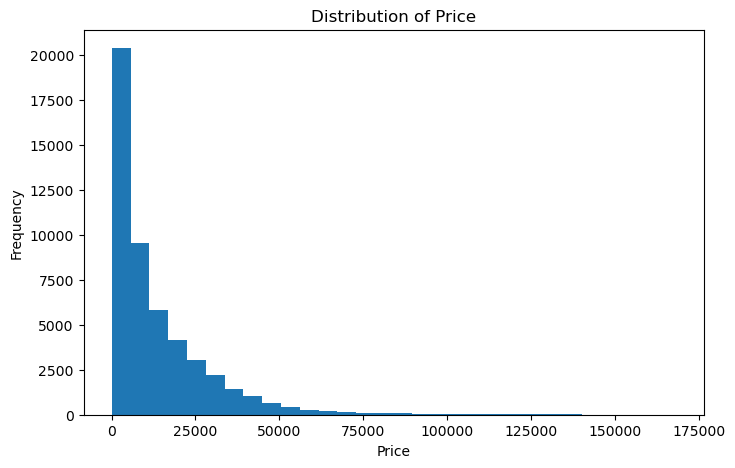

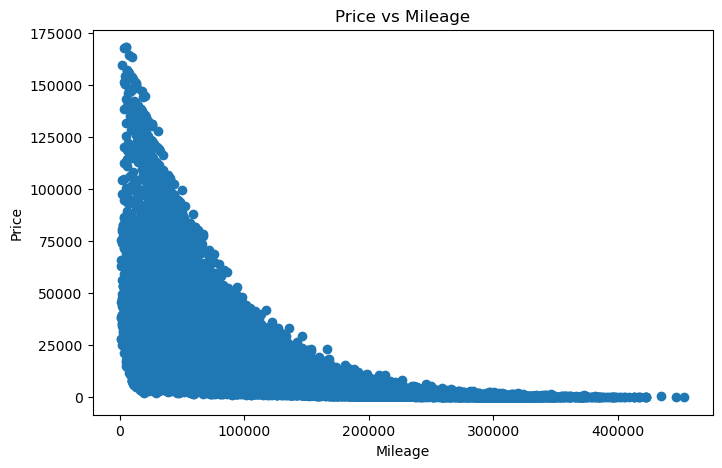

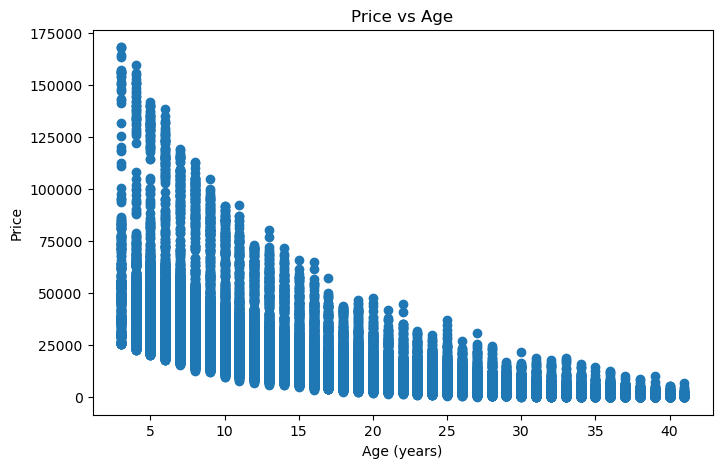

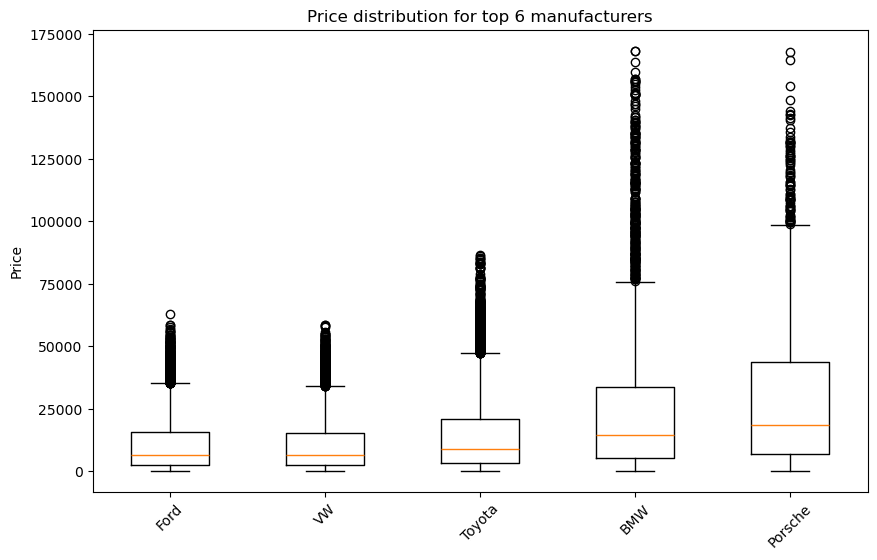

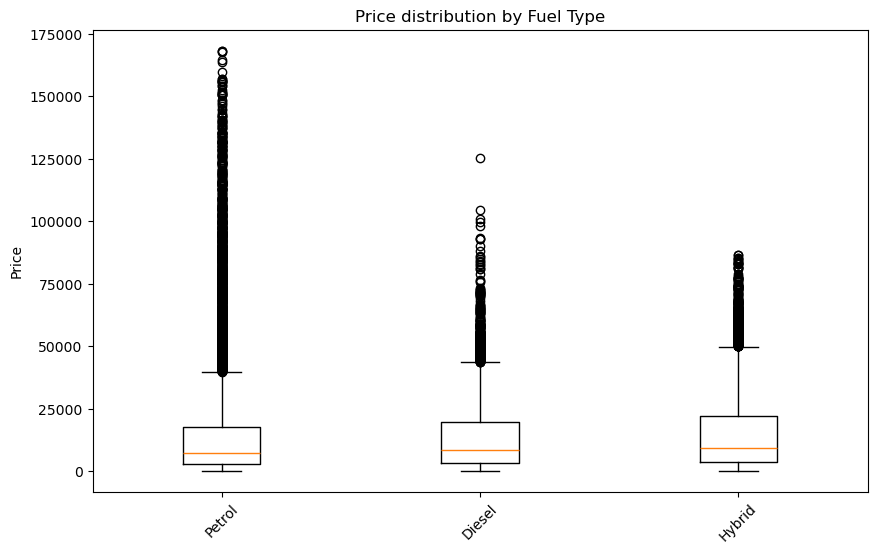

In [16]:
# ---------- 5. Visualizations (Matplotlib only) ----------
# 5.1 Histogram of Price
plt.figure(figsize=(8,5))
plt.hist(df['price'].dropna(), bins=30)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 5.2 Scatter: Price vs Mileage
plt.figure(figsize=(8,5))
plt.scatter(df['mileage'], df['price'])
plt.title('Price vs Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

# 5.3 Scatter: Price vs Age (if age exists)
if 'age' in df.columns:
    plt.figure(figsize=(8,5))
    plt.scatter(df['age'], df['price'])
    plt.title('Price vs Age')
    plt.xlabel('Age (years)')
    plt.ylabel('Price')
    plt.show()

# 5.4 Boxplots: Price by top manufacturers (top N by count)
top_n = 6
if 'manufacturer' in df.columns:
    top_manufs = df['manufacturer'].value_counts().nlargest(top_n).index.tolist()
    data_to_plot = [df.loc[df['manufacturer'] == m, 'price'].dropna() for m in top_manufs]
    plt.figure(figsize=(10,6))
    plt.boxplot(data_to_plot)
    plt.xticks(range(1, len(top_manufs)+1), top_manufs, rotation=45)
    plt.title(f'Price distribution for top {top_n} manufacturers')
    plt.ylabel('Price')
    plt.show()

# 5.5 Boxplots: Price by Fuel Type (if present)
if 'fuel_type' in df.columns:
    types = df['fuel_type'].dropna().unique().tolist()
    data_ft = [df.loc[df['fuel_type'] == t, 'price'].dropna() for t in types if len(df.loc[df['fuel_type'] == t])>0]
    if len(data_ft) > 0:
        plt.figure(figsize=(10,6))
        plt.boxplot(data_ft)
        plt.xticks(range(1, len(types)+1), types, rotation=45)
        plt.title('Price distribution by Fuel Type')
        plt.ylabel('Price')
        plt.show()



Correlation matrix:


,price,mileage,engine_size,year_of_manufacture,age
price,1.000000,-0.632692,0.398371,0.714209,-0.714209
mileage,-0.632692,1.000000,0.004470,-0.807458,0.807458
engine_size,0.398371,0.004470,1.000000,-0.000675,0.000675
year_of_manufacture,0.714209,-0.807458,-0.000675,1.000000,-1.000000
age,-0.714209,0.807458,0.000675,-1.000000,1.000000


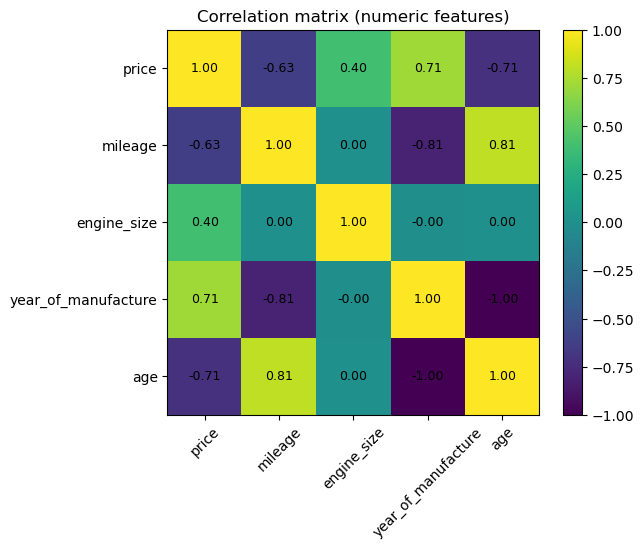

In [17]:
# ---------- 6. Correlation analysis ----------
# Compute correlations among numeric features
corr_cols = [c for c in ['price', 'mileage', 'engine_size', 'year_of_manufacture', 'age'] if c in df.columns]
corr = df[corr_cols].corr()
print("\nCorrelation matrix:")
display(corr)

# Visualize correlation matrix with matplotlib (annotated)
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title('Correlation matrix (numeric features)')
# Annotate correlation values
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = corr.iloc[i,j]
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9)
plt.show()


In [18]:
# ---------- 7. Outlier detection for Price (IQR method) ----------
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_mask = (df['price'] < lower_bound) | (df['price'] > upper_bound)
outliers_count = outliers_mask.sum()
print(f"\nPrice outliers detected by IQR method: {outliers_count} rows out of {len(df)} ({outliers_count/len(df):.2%})")
if outliers_count > 0:
    display(df.loc[outliers_mask, ['manufacturer','model','year_of_manufacture','mileage','price']].head(10))

# ---------- 8. Grouped analysis (average price by manufacturer & fuel type) ----------
if 'manufacturer' in df.columns:
    manuf_summary = df.groupby('manufacturer')['price'].agg(['count','mean','median']).sort_values('count', ascending=False)
    print("\nManufacturer summary (count, mean, median price):")
    if can_display:
        display_dataframe_to_user("manufacturer_summary", manuf_summary.reset_index())
    else:
        display(manuf_summary.head(20))

if 'fuel_type' in df.columns:
    fuel_summary = df.groupby('fuel_type')['price'].agg(['count','mean','median']).sort_values('count', ascending=False)
    print("\nFuel type summary (count, mean, median price):")
    display(fuel_summary)

# ---------- 9. Simple predictive model: Linear Regression (price ~ mileage + age + engine_size) ----------
# Prepare features and target. Drop rows with missing values in features.
features = [c for c in ['mileage','age','engine_size'] if c in df.columns]
print("\nFeatures used for simple regression:", features)
model_df = df.dropna(subset=features + ['price']).copy()

X = model_df[features].values
y = model_df['price'].values


Price outliers detected by IQR method: 2649 rows out of 50000 (5.30%)


,manufacturer,model,year_of_manufacture,mileage,price
1,Porsche,718 Cayman,2016,57850,49704
18,Toyota,RAV4,2018,28381,52671
41,BMW,M5,2017,22759,97758
51,Toyota,RAV4,2018,24588,49125
57,Porsche,Cayenne,2015,33693,54037
81,Porsche,718 Cayman,2021,14070,69526
109,Toyota,RAV4,2021,6829,66031
136,BMW,X3,2018,20441,53379
145,BMW,X3,2018,27389,44018
153,Porsche,718 Cayman,2018,20634,70913



Manufacturer summary (count, mean, median price):


,count,mean,median
manufacturer,,,
Ford,14959,10672.288723,6646.0
VW,14913,10363.139274,6428.0
Toyota,12554,14340.362275,8802.0
BMW,4965,24429.459215,14384.0
Porsche,2609,29103.764661,18441.0



Fuel type summary (count, mean, median price):


,count,mean,median
fuel_type,,,
Petrol,25488,13690.617742,7266.0
Diesel,13268,13145.078158,8348.5
Hybrid,11244,14949.288154,9357.0



Features used for simple regression: ['mileage', 'age', 'engine_size']


In [19]:
if len(model_df) >= 30 and X.shape[1] > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nLinear Regression results:\n R^2 on test set: {r2:.4f}\n RMSE on test set: {rmse:.2f}")
    # Coefficients mapping
    coef_df = pd.DataFrame({'feature': features, 'coefficient': lr.coef_})
    display(coef_df)
else:
    print("\nNot enough data to train the regression model or no numeric features found for modeling.")

# ---------- 10. Recommendations (printed summary) ----------
print("\n--- Recommendations (based on EDA & simple modeling) ---")
print("1) Mileage and age commonly show negative relationships with price: highlight low mileage and recent manufacture year when selling.")
print("2) Engine size may have mixed effects; if the coefficient is positive, larger engines keep higher prices (check 'coef_df' above).")
print("3) Certain manufacturers hold value better — use the manufacturer summary to price accordingly.")
print("4) Handle outliers carefully: extremely low/high prices may be data errors or special cases (collect more info on those rows).")
print("5) For more accurate pricing models, consider adding more features (trim, transmission, number of owners, service history) and using tree-based models (RandomForest, XGBoost) after encoding categorical variables.")



Linear Regression results:
 R^2 on test set: 0.6715
 RMSE on test set: 9442.38


,feature,coefficient
0,mileage,-0.038014
1,age,-987.317147
2,engine_size,8931.978776



--- Recommendations (based on EDA & simple modeling) ---
1) Mileage and age commonly show negative relationships with price: highlight low mileage and recent manufacture year when selling.
2) Engine size may have mixed effects; if the coefficient is positive, larger engines keep higher prices (check 'coef_df' above).
3) Certain manufacturers hold value better — use the manufacturer summary to price accordingly.
4) Handle outliers carefully: extremely low/high prices may be data errors or special cases (collect more info on those rows).
5) For more accurate pricing models, consider adding more features (trim, transmission, number of owners, service history) and using tree-based models (RandomForest, XGBoost) after encoding categorical variables.
